# Overview of SwissLandStats

The `swisslandstats-geopy` provides an extended pandas-like interface to the [Swiss Federal Statistics Geodata](https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata.html) from the Swiss Federal Statistics Office (SFSO). In this notebook, we show how it can be used with the land use statistics as well as with the population and household statistics (STATPOP).

In [ ]:
import swisslandstats as sls

## IO and plotting

We can read the land statistics file directly from the SFSO website using the `from_url` method. The first time can take a while since the whole dataset (696 MB CSV file) has to be downloaded. By default, the file is cached so that subsequent calls can load it directly. Nonetheless, it still may be a bit slow to read since there are over 4.1 million rows (each hectare of the Swiss territory):

In [ ]:
ldf = sls.from_url()
ldf

,E_COORD,N_COORD,GMDE,GMDE_HISTID,FJ85,FJ97,FJ09,FJ18,FJ25,METHOD25,...,LU85_10,LU97_10,LU09_10,LU18_10,LU25_10,LU85_4,LU97_4,LU09_4,LU18_4,LU25_4
RELI,,,,,,,,,,,,,,,,,,,,,
54731894,2547300,1189400,9154,10257,1979,1990,2005,2014,2020.0,1.0,...,400,400,400,400,400.0,4,4,4,4,4.0
54761955,2547600,1195500,6417,16121,1979,1990,2005,2014,NaN,NaN,...,300,300,300,300,NaN,3,3,3,3,NaN
54762001,2547600,1200100,6413,16093,1979,1990,2005,2014,NaN,NaN,...,300,300,300,300,NaN,3,3,3,3,NaN
54762009,2547600,1200900,6413,16093,1979,1990,2005,2014,NaN,NaN,...,220,220,220,220,NaN,2,2,2,2,NaN
54762058,2547600,1205800,6437,16104,1979,1990,2005,2014,NaN,NaN,...,220,220,220,220,NaN,2,2,2,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61052561,2610500,1256100,2772,13835,1982,1994,2005,2014,NaN,NaN,...,220,220,220,220,NaN,2,2,2,2,NaN
61052589,2610500,1258900,2761,13824,1982,1994,2005,2014,NaN,NaN,...,220,220,220,220,NaN,2,2,2,2,NaN
61071443,2610700,1144300,561,15137,1980,1992,2004,2013,NaN,NaN,...,240,240,240,240,NaN,2,2,2,2,NaN


Then `ldf` will be a `LandDataFrame` object, which extends a pandas `DataFrame` with some methods aimed to process geographic raster data.

In [ ]:
ldf.head()

,E_COORD,N_COORD,GMDE,GMDE_HISTID,FJ85,FJ97,FJ09,FJ18,FJ25,METHOD25,...,LU85_10,LU97_10,LU09_10,LU18_10,LU25_10,LU85_4,LU97_4,LU09_4,LU18_4,LU25_4
RELI,,,,,,,,,,,,,,,,,,,,,
54731894,2547300,1189400,9154,10257,1979,1990,2005,2014,2020.0,1.0,...,400.0,400.0,400.0,400.0,400.0,4.0,4.0,4.0,4.0,4.0
54761955,2547600,1195500,6417,16121,1979,1990,2005,2014,NaN,NaN,...,300.0,300.0,300.0,300.0,NaN,3.0,3.0,3.0,3.0,NaN
54762001,2547600,1200100,6413,16093,1979,1990,2005,2014,NaN,NaN,...,300.0,300.0,300.0,300.0,NaN,3.0,3.0,3.0,3.0,NaN
54762009,2547600,1200900,6413,16093,1979,1990,2005,2014,NaN,NaN,...,220.0,220.0,220.0,220.0,NaN,2.0,2.0,2.0,2.0,NaN
54762058,2547600,1205800,6437,16104,1979,1990,2005,2014,NaN,NaN,...,220.0,220.0,220.0,220.0,NaN,2.0,2.0,2.0,2.0,NaN


Each row corresponds to a pixel, where `E_COORD`, `N_COORD` denote the coordinates of its centroid (in the [LV95 coordinate system](https://www.swisstopo.admin.ch/en/knowledge-facts/surveying-geodesy/reference-frames/local/lv95.html).

The `FJ85`, `FJ97`, `FJ09`, `FJ18` and `FJ25` denote the exact years when the observations for each of the four survey periods were taken. See [the datset description (link in French)](https://www.bfs.admin.ch/bfs/fr/home/services/geostat/geodonnees-statistique-federale/sol-utilisation-couverture/statistique-suisse-superficie.html) for more information. The columns of the form *LU{survey_period}_{num_classes}* denote the land use/land cover class at its respective survey period. The free tier includes classifications for 17 and 4 land use/land cover classes.

Let us first plot a land use/land cover column, e.g., the land use/land cover [classified into the 4 main classes](https://www.bfs.admin.ch/bfs/fr/home/services/geostat/geodonnees-statistique-federale/sol-utilisation-couverture/statistique-suisse-superficie/nomenclature-standard.html) for the 2013/18 survey. We can use any colormap that works with matplotlib. In this example, we will use one that is well suited for the 4 main classes classification, which is included within the swisslandastats library:

<Axes: >

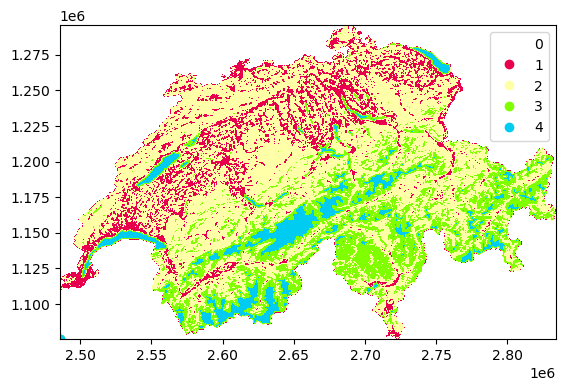

In [ ]:
ldf.plot("LU18_4", cmap=sls.noas04_4_cmap, norm=sls.noas04_4_norm, legend=True)

See the documentation for `LandDataFrame.plot` for more details.

On the other hand, we can use the `to_ndarray` method to transform any column to a numpy array:

In [ ]:
ldf.to_ndarray("LU18_4")

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Or also export any column to a GeoTiff file by means of the `to_geotiff` method, where the first argument corresponds to the output file path, and the second to the data column:

In [ ]:
ldf.to_geotiff("LU18_4.tif", "LU18_4")

## Basic transformations

We can operate over a `LandDataFrame` as we would do with any pandas `DataFrame`. For example, we can create a new column that represents the pixels that have been transformed from non-urban to urban during the 2004/09-2013/18 period:

In [ ]:
ldf["urban_09-18"] = (ldf["LU18_4"] == 1) & (ldf["LU09_4"] != 1)

Let us plot the new column:

<Axes: >

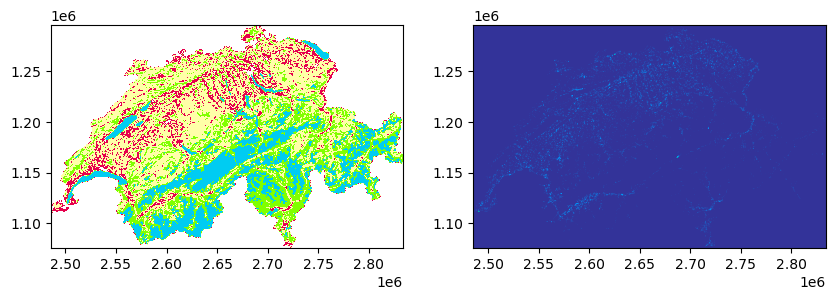

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ldf.plot("LU09_4", cmap=sls.noas04_4_cmap, ax=axes[0])
ldf.plot("urban_09-18", ax=axes[1])

We might also subset our region by selecting a set of rows of interest:

In [ ]:
ldf.iloc[:100000].plot("lu09_4", cmap=sls.noas04_4_cmap)

## Geometric transformations

Selecting pixel rows is not the most natural way to extract geographic regions. Instead, we can clip a `LandDataFrame` instance to the extents of a given geometry. Note that .

Let us first use osmnx in order to obtain the bounds of a region of interest, e.g., the municipality of Lausanne:

In [ ]:
import osmnx as ox

geometry = ox.geocode_to_gdf("Lausanne, Vaud")["geometry"].iloc[0]

Now we can use the `clip_by_geometry` method in order to clip the `LandDataFrame` to the extents of such geometry. Just note that the [coordinate reference system](https://en.wikipedia.org/wiki/Spatial_reference_system) of the geometry must be provided, otherwise, the one from the swisslandstats' `settings` module will be taken (i.e., [EPSG:2056](https://spatialreference.org/ref/epsg/2056) by default). Since the geometry of this example has been extracted from the OpenStreetMap, it will be in [EPSG:4326](https://spatialreference.org/ref/epsg/4326).

<Axes: >

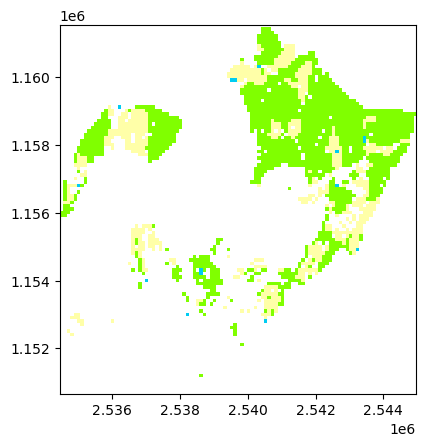

In [ ]:
subset_ldf = ldf.clip_by_geometry(geometry, geometry_crs=ox.settings.default_crs)
subset_ldf.plot("LU09_4", cmap=sls.noas04_4_cmap)

In fact, the `clip_by_nominatim` method provides a shortcut for what has been done above:

In [ ]:
same_subset_ldf = ldf.clip_by_nominatim("Lausanne, Vaud")
same_subset_ldf.plot("LU09_4", cmap=sls.noas04_4_cmap)

## Population and household statistics: STATPOP

Let us now download and unzip the [population and household statistics](https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata/population-buildings-dwellings-persons/population-housholds-from-2010.html) (note that the `make` command in the cell below will probably not work in Windows - in such case you might [click here](https://www.bfs.admin.ch/bfsstatic/dam/assets/9947069/master) to download the data manually).

In [ ]:
!make download_statpop

curl https://dam-api.bfs.admin.ch/hub/api/dam/assets/27965868/master -o data/statpop/STATPOP2022.zip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.4M    0 11.4M    0     0  1268k      0 --:--:--  0:00:09 --:--:-- 1205k
unzip -j data/statpop/STATPOP2022.zip 'ag-b-00.03-vz2022statpop/STATPOP2022.csv' -d data/statpop
Archive:  data/statpop/STATPOP2022.zip
  inflating: data/statpop/STATPOP2022.csv  
touch data/statpop/STATPOP2022.csv
rm data/statpop/STATPOP2022.zip


Given a path to a local CSV file, we can use the `read_csv` method to load it into a land data frame:

In [ ]:
statpop_ldf = sls.read_csv("data/statpop/STATPOP2022.csv")
statpop_ldf.head()

,E_KOORD,N_KOORD,B22BTOT,B22B11,B22B12,B22B13,B22B14,B22B15,B22B16,B22B21,...,B22B55,B22B56,H22PTOT,H22P01,H22P02,H22P03,H22P04,H22P05,H22P06,H22PI
RELI,,,,,,,,,,,,,,,,,,,,,
48621114,2486200,1111400,6,5,3,3,0,0,0,4,...,0,0,3,0,0,0,0,0,3,1
48621115,2486200,1111500,3,3,3,0,3,0,0,3,...,0,0,3,3,0,0,0,0,0,1
48631114,2486300,1111400,4,4,0,0,0,0,0,4,...,0,0,3,0,0,0,3,0,0,1
48631115,2486300,1111500,3,0,3,0,3,0,0,3,...,0,0,3,0,0,3,0,0,0,1
48631117,2486300,1111700,3,3,0,0,0,0,0,3,...,0,0,3,0,0,3,0,0,0,1


Let us focus on the Canton of Vaud only:

In [ ]:
statpop_ldf = statpop_ldf.clip_by_nominatim("Vaud, Switzerland")

Among other information, STATPOP provides a set of columns with the permanent resident population by age group and sex. These are of the form 'B{jj}B{sex}{age_group}', where 'jj' corresponds to the year (in this example, we have '22' for 2022), 'sex' can be either 'M' (man) or 'W' (woman), and 'age_group' is a two-digit integer (zero-padded when necessary) that represents a 5-year age range from '01' (under 4 years old) to '19' (90 and older).

Let us plot the male population in the 65-69 age range, i.e., 'B22BM14':

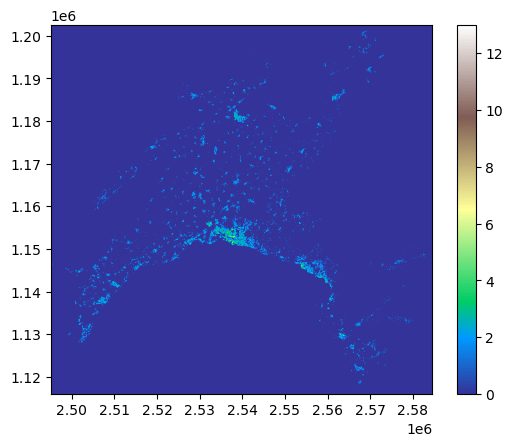

In [ ]:
ax = statpop_ldf.plot("B22BM14")
plt.colorbar(ax.get_images()[0])

We can perform any kind of pandas-like operation in our `statpop_ldf` instance. For example, let us compute the total population considered most "vulnerable" to urban heat exposure, e.g., ages under 14 and over 60 for both sexes:

In [ ]:
vulnerable_columns = [
    f"B22B{sex}{age_group:02}"
    for sex in ["M", "W"]
    for age_group in list(range(1, 4)) + list(range(13, 20))
]
statpop_ldf["vulnerable"] = statpop_ldf[vulnerable_columns].sum(axis=1)

We can now plot this information as we would with any other column:

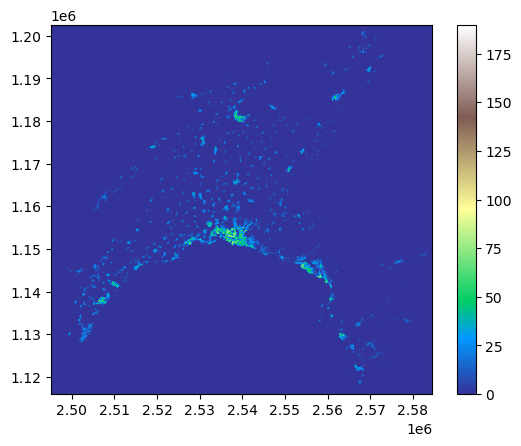

In [ ]:
ax = statpop_ldf.plot("vulnerable")
plt.colorbar(ax.get_images()[0])